<a href="https://colab.research.google.com/github/oxanaRC/CE902/blob/main/Random_forest_test240721.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

24.07.21
Joining property sales dataset with local schools data (number of secondary schools in radius of 6 km and disadvantage pupils score). 
Joining property sales data with historic (3 mnths) median prices per bedroom
RF on a subset of data (Colchester, Chelmsford, Ipswich, Bury St Edmunds and Uttlesford areas for 12 months - Jan, Feb, Mar, Apr, May, June, Jul, Aug, Sep, Oct, Nov, Dec 2018) - comparing RMSE for predictions obtained from data withiot disadvantage score and with)




In [1]:
!pip install harperdb

In [2]:
import harperdb
import pandas as pd
import numpy as np
from pathlib import Path

In [3]:
url='https://ce901data-orc0770.harperdbcloud.com'
db=harperdb.HarperDB(url=url,
            username='myuser',
            password='abcdef',
            timeout=500)

In [4]:
db

Below data is extracted from the SQL database, however because of poor performance of the JOIN SQL operations, instead of relational SQL statements, the JOIN operations are performed in pandas DataFrames (according to https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html).


The data extraction from SQL tables in placed within the loop to avoid the database timeout issues.

This extracts property sales data.



In [5]:
list_of_dfs = {}
count=0
for mt in range(1, 11):
  for yr in range (2018,2019):
    year=yr
    month=mt
    count=count+1
    #sqlstring1='SELECT bedrooms.id, bedrooms.num_of_beds, propertypurchases.price_paid, propertypurchases.town, propertypurchases.district, propertypurchases.estate_type, propertypurchases.property_type, propertypurchases.deed_date '
    #sqlstring2='FROM projectdata.bedrooms LEFT OUTER JOIN projectdata.propertypurchases ON bedrooms.id=propertypurchases.unique_id WHERE (num_of_beds>0 and deed_date LIKE "%{}/{}")'
    #sqlstring2='FROM projectdata.bedrooms LEFT OUTER JOIN projectdata.propertypurchases ON bedrooms.id=propertypurchases.unique_id WHERE deed_date LIKE "%{}/{}"'
    #sqlstring=sqlstring1+sqlstring2
    sqlstring='SELECT propertypurchases.unique_id, propertypurchases.price_paid, propertypurchases.town, propertypurchases.district, propertypurchases.estate_type, propertypurchases.property_type, propertypurchases.deed_date, propertypurchases.postcode FROM projectdata.propertypurchases WHERE deed_date LIKE "%{}/{}"'
    sqlstring=sqlstring.format(month,year)
    print(sqlstring)
    my_db_data=db.sql(sqlstring)
    list_of_dfs[count] = pd.DataFrame(my_db_data)
    print(list_of_dfs[count].shape)
df_prop_sales = pd.concat(list_of_dfs, sort=False)
#excluding 'other' property types (i.e. commercial) from the properties sales data 
df_prop_sales=df_prop_sales[(df_prop_sales['property_type']!='O')]
df_prop_sales

SELECT propertypurchases.unique_id, propertypurchases.price_paid, propertypurchases.town, propertypurchases.district, propertypurchases.estate_type, propertypurchases.property_type, propertypurchases.deed_date, propertypurchases.postcode FROM projectdata.propertypurchases WHERE deed_date LIKE "%1/2018"
(169065, 8)
SELECT propertypurchases.unique_id, propertypurchases.price_paid, propertypurchases.town, propertypurchases.district, propertypurchases.estate_type, propertypurchases.property_type, propertypurchases.deed_date, propertypurchases.postcode FROM projectdata.propertypurchases WHERE deed_date LIKE "%2/2018"
(157760, 8)
SELECT propertypurchases.unique_id, propertypurchases.price_paid, propertypurchases.town, propertypurchases.district, propertypurchases.estate_type, propertypurchases.property_type, propertypurchases.deed_date, propertypurchases.postcode FROM projectdata.propertypurchases WHERE deed_date LIKE "%3/2018"
(84147, 8)
SELECT propertypurchases.unique_id, propertypurchases

unique_id  ...  postcode
1  0      64342BFD-ABA7-422C-E053-6C04A8C0FB8A  ...    E8 4NE
   1      64342BFD-ABAA-422C-E053-6C04A8C0FB8A  ...    N5 1BZ
   2      64342BFD-ABAB-422C-E053-6C04A8C0FB8A  ...   W11 1NZ
   3      64342BFD-ABAC-422C-E053-6C04A8C0FB8A  ...   IG3 9NB
   4      64342BFD-ABB0-422C-E053-6C04A8C0FB8A  ...   W12 8JN
...                                        ...  ...       ...
10 93062  C18F412B-1446-81A6-E053-6B04A8C0AD18  ...  CH42 2AQ
   93063  C18F412B-14DD-81A6-E053-6B04A8C0AD18  ...   L36 9TG
   93064  C18F412B-795D-81A6-E053-6B04A8C0AD18  ...   B31 2NA
   93065  C18F412B-94F2-81A6-E053-6B04A8C0AD18  ...   LS7 4AG
   93066  C18F412B-97A6-81A6-E053-6B04A8C0AD18  ...   E14 9XD

[964028 rows x 8 columns]

Below extracting number of bedrooms data for each property sale id.


In [6]:
sqlstring='SELECT bedrooms.id, bedrooms.num_of_beds FROM projectdata.bedrooms WHERE num_of_beds>0'
bedrooms=db.sql(sqlstring)
df_bedrooms=pd.DataFrame(bedrooms)
df_bedrooms.rename(columns = {'id':'unique_id'}, inplace = True)
df_bedrooms

,unique_id,num_of_beds
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1
1,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1
2,79A74E21-DB3C-1289-E053-6B04A8C01627,1
3,79A74E21-1F11-1289-E053-6B04A8C01627,1
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1
...,...,...
596427,80E1AA98-910A-7BF8-E053-6C04A8C00BF2,23
596428,64342BFF-158B-422C-E053-6C04A8C0FB8A,23
596429,80E1AA98-773C-7BF8-E053-6C04A8C00BF2,32
596430,75050A86-10FB-9A88-E053-6B04A8C02390,46


In [7]:
#merging bedrooms data with property sales data.
data = pd.merge(df_bedrooms, df_prop_sales, how="left", on="unique_id")
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG
1,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX
2,79A74E21-DB3C-1289-E053-6B04A8C01627,1,33000.0,LIVERPOOL,LIVERPOOL,L,F,21/09/2018,L5 4TD
3,79A74E21-1F11-1289-E053-6B04A8C01627,1,405000.0,LONDON,HAMMERSMITH AND FULHAM,L,F,27/09/2018,W14 9BW
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1,156500.0,HAVERHILL,ST EDMUNDSBURY,F,T,29/03/2018,CB9 0EH
...,...,...,...,...,...,...,...,...,...
596427,80E1AA98-910A-7BF8-E053-6C04A8C00BF2,23,335000.0,SUTTON,SUTTON,F,S,19/12/2018,SM1 2EG
596428,64342BFF-158B-422C-E053-6C04A8C0FB8A,23,80000.0,WOLVERHAMPTON,WOLVERHAMPTON,F,T,12/01/2018,WV2 4NA
596429,80E1AA98-773C-7BF8-E053-6C04A8C00BF2,32,108000.0,NOTTINGHAM,CITY OF NOTTINGHAM,F,S,19/12/2018,NG8 3AA
596430,75050A86-10FB-9A88-E053-6B04A8C02390,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#check rows where postcode is NAN - these are the result of rows added on the Join with bedrooms data where bedrooms data is for sale happened after the considered period
#data_t=data[ (data['postcode'].isnull()) ]
#drop NAN rows from data
data=data.dropna(subset=['postcode'])     
data 

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG
1,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX
2,79A74E21-DB3C-1289-E053-6B04A8C01627,1,33000.0,LIVERPOOL,LIVERPOOL,L,F,21/09/2018,L5 4TD
3,79A74E21-1F11-1289-E053-6B04A8C01627,1,405000.0,LONDON,HAMMERSMITH AND FULHAM,L,F,27/09/2018,W14 9BW
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1,156500.0,HAVERHILL,ST EDMUNDSBURY,F,T,29/03/2018,CB9 0EH
...,...,...,...,...,...,...,...,...,...
596426,80E1AA98-910A-7BF8-E053-6C04A8C00BF2,23,335000.0,SUTTON,SUTTON,F,S,19/12/2018,SM1 2EG
596427,80E1AA98-910A-7BF8-E053-6C04A8C00BF2,23,335000.0,SUTTON,SUTTON,F,S,19/12/2018,SM1 2EG
596428,64342BFF-158B-422C-E053-6C04A8C0FB8A,23,80000.0,WOLVERHAMPTON,WOLVERHAMPTON,F,T,12/01/2018,WV2 4NA
596429,80E1AA98-773C-7BF8-E053-6C04A8C00BF2,32,108000.0,NOTTINGHAM,CITY OF NOTTINGHAM,F,S,19/12/2018,NG8 3AA


In [9]:
#removing duplicates (some bedroom data was loaded twice by mistake)
data=data.drop_duplicates()
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG
1,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX
2,79A74E21-DB3C-1289-E053-6B04A8C01627,1,33000.0,LIVERPOOL,LIVERPOOL,L,F,21/09/2018,L5 4TD
3,79A74E21-1F11-1289-E053-6B04A8C01627,1,405000.0,LONDON,HAMMERSMITH AND FULHAM,L,F,27/09/2018,W14 9BW
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1,156500.0,HAVERHILL,ST EDMUNDSBURY,F,T,29/03/2018,CB9 0EH
...,...,...,...,...,...,...,...,...,...
596425,6B32222C-0F70-01F1-E053-6C04A8C0D2C8,17,140000.0,PONTYPOOL,TORFAEN,F,T,05/01/2018,NP4 6DA
596426,80E1AA98-910A-7BF8-E053-6C04A8C00BF2,23,335000.0,SUTTON,SUTTON,F,S,19/12/2018,SM1 2EG
596428,64342BFF-158B-422C-E053-6C04A8C0FB8A,23,80000.0,WOLVERHAMPTON,WOLVERHAMPTON,F,T,12/01/2018,WV2 4NA
596429,80E1AA98-773C-7BF8-E053-6C04A8C00BF2,32,108000.0,NOTTINGHAM,CITY OF NOTTINGHAM,F,S,19/12/2018,NG8 3AA


In [10]:
#Extracting sales-postcodes-mappings-to-schools-postcodes 
#Extraction of  sales-postcodes-mappings-to-schools-postcodes' has to be done in batches to prevent timeout issues 
list_of_dfs_sm = {}
my_range_a=0
count=0
for x in range(1, 20):
    my_range_b=x*10000
    my_range_a=my_range_b-10000
    count=count+1
    sqlstring='SELECT sales_pc_to_school_ps_map.sales_postcode,  sales_pc_to_school_ps_map.urn, sales_pc_to_school_ps_map.distance, sales_pc_to_school_ps_map.disadv_prct, sales_pc_to_school_ps_map.aver_attain_eng , sales_pc_to_school_ps_map.aver_attain_math FROM projectdata. sales_pc_to_school_ps_map  WHERE count_p >= {} and count_p <{}'
    sqlstring=sqlstring.format(my_range_a,my_range_b)
    print(sqlstring)
    my_db_data=db.sql(sqlstring)
    list_of_dfs_sm[count] = pd.DataFrame(my_db_data)
    print(list_of_dfs_sm[count].shape)
df_local_schools = pd.concat(list_of_dfs_sm, sort=False)
df_local_schools


SELECT sales_pc_to_school_ps_map.sales_postcode,  sales_pc_to_school_ps_map.urn, sales_pc_to_school_ps_map.distance, sales_pc_to_school_ps_map.disadv_prct, sales_pc_to_school_ps_map.aver_attain_eng , sales_pc_to_school_ps_map.aver_attain_math FROM projectdata. sales_pc_to_school_ps_map  WHERE count_p >= 0 and count_p <10000
(727849, 6)
SELECT sales_pc_to_school_ps_map.sales_postcode,  sales_pc_to_school_ps_map.urn, sales_pc_to_school_ps_map.distance, sales_pc_to_school_ps_map.disadv_prct, sales_pc_to_school_ps_map.aver_attain_eng , sales_pc_to_school_ps_map.aver_attain_math FROM projectdata. sales_pc_to_school_ps_map  WHERE count_p >= 10000 and count_p <20000
(557163, 6)
SELECT sales_pc_to_school_ps_map.sales_postcode,  sales_pc_to_school_ps_map.urn, sales_pc_to_school_ps_map.distance, sales_pc_to_school_ps_map.disadv_prct, sales_pc_to_school_ps_map.aver_attain_eng , sales_pc_to_school_ps_map.aver_attain_math FROM projectdata. sales_pc_to_school_ps_map  WHERE count_p >= 20000 and count

sales_postcode       urn  ...  aver_attain_eng aver_attain_math
1  0           LL13 9QX       0.0  ...              0.0              0.0
   1           RH13 8BH       0.0  ...              0.0              0.0
   2            M27 9UR  138418.0  ...              6.7              6.0
   3            M27 9UR  131512.0  ...              9.7              9.3
   4            M27 9UR  143059.0  ...              7.9              7.1
...                 ...       ...  ...              ...              ...
17 38165        BL7 9HU  144044.0  ...             11.3             10.8
   38166        BL7 9HU  145314.0  ...              6.9              6.4
   38167        BL7 9HU  141941.0  ...              7.6              7.4
   38168        BL7 9HU  142340.0  ...             12.8             10.8
   38169        BL7 9HU  105253.0  ...             10.3              8.8

[4271081 rows x 6 columns]

In [12]:
#the school data contains special schools
data_test = df_local_schools[(df_local_schools['disadv_prct']=='NP')]
data_test


sales_postcode       urn  ...  aver_attain_eng aver_attain_math
1  67           SK4 2HZ  134064.0  ...              0.6              1.8
   935         BH14 9HQ  113954.0  ...              0.3              1.1
   1099        BH12 2HU  113954.0  ...              0.3              1.1
   1543         SK2 6ES  134064.0  ...              0.6              1.8
   1914         L17 3BB  104734.0  ...              0.7              0.9
...                 ...       ...  ...              ...              ...
17 36582        BH9 1HJ  113954.0  ...              0.3              1.1
   36804       DE22 2JH  113044.0  ...              1.4              1.0
   36910       BH14 8PY  113954.0  ...              0.3              1.1
   37907       RG14 7SF  110180.0  ...              5.3              6.2
   37956        SK4 4ED  134064.0  ...              0.6              1.8

[16870 rows x 6 columns]

In [13]:
#remove special schools 
df_local_schools.drop(df_local_schools[df_local_schools['disadv_prct']=='NP'].index, inplace = True)
df_local_schools

sales_postcode       urn  ...  aver_attain_eng aver_attain_math
1  0           LL13 9QX       0.0  ...              0.0              0.0
   1           RH13 8BH       0.0  ...              0.0              0.0
   2            M27 9UR  138418.0  ...              6.7              6.0
   3            M27 9UR  131512.0  ...              9.7              9.3
   4            M27 9UR  143059.0  ...              7.9              7.1
...                 ...       ...  ...              ...              ...
17 38165        BL7 9HU  144044.0  ...             11.3             10.8
   38166        BL7 9HU  145314.0  ...              6.9              6.4
   38167        BL7 9HU  141941.0  ...              7.6              7.4
   38168        BL7 9HU  142340.0  ...             12.8             10.8
   38169        BL7 9HU  105253.0  ...             10.3              8.8

[4254211 rows x 6 columns]

In [14]:
#cheking if the school mappings data contains Nan
data_test = df_local_schools[(df_local_schools['disadv_prct'].isnull())]
data_test

,,sales_postcode,urn,distance,disadv_prct,aver_attain_eng,aver_attain_math


In [15]:
#adding 'weights' to the school mapping data: calculated as 6km minus the distance from the sale postcode to a school
#the closer a school to the postocode, the greater the weight of that school
df_local_schools['weight']=6-df_local_schools['distance']
df_local_schools['disadv_prct']=df_local_schools['disadv_prct'].str.replace('%','')
df_local_schools['disadv_prct'] = df_local_schools['disadv_prct'].replace(np.nan, 0)  #fillna(0)
df_local_schools['disadv_prct'] = df_local_schools['disadv_prct']. fillna(0)
df_local_schools['disadv_prct']= pd.to_numeric(df_local_schools['disadv_prct'], downcast='float')
df_local_schools

sales_postcode       urn  ...  aver_attain_math    weight
1  0           LL13 9QX       0.0  ...               0.0  6.000000
   1           RH13 8BH       0.0  ...               0.0  6.000000
   2            M27 9UR  138418.0  ...               6.0  0.580426
   3            M27 9UR  131512.0  ...               9.3  2.112568
   4            M27 9UR  143059.0  ...               7.1  1.813905
...                 ...       ...  ...               ...       ...
17 38165        BL7 9HU  144044.0  ...              10.8  3.681288
   38166        BL7 9HU  145314.0  ...               6.4  1.960444
   38167        BL7 9HU  141941.0  ...               7.4  0.804329
   38168        BL7 9HU  142340.0  ...              10.8  0.017824
   38169        BL7 9HU  105253.0  ...               8.8  4.788904

[4254211 rows x 7 columns]

In [16]:
#calculating a score for each school mapping
df_local_schools['score_disadv']=df_local_schools['weight'].astype(float)*df_local_schools['disadv_prct'].astype(float)
df_local_schools

sales_postcode       urn  ...    weight  score_disadv
1  0           LL13 9QX       0.0  ...  6.000000      0.000000
   1           RH13 8BH       0.0  ...  6.000000      0.000000
   2            M27 9UR  138418.0  ...  0.580426     35.406015
   3            M27 9UR  131512.0  ...  2.112568    111.966088
   4            M27 9UR  143059.0  ...  1.813905     83.439647
...                 ...       ...  ...       ...           ...
17 38165        BL7 9HU  144044.0  ...  3.681288     40.494167
   38166        BL7 9HU  145314.0  ...  1.960444     92.140848
   38167        BL7 9HU  141941.0  ...  0.804329     43.433767
   38168        BL7 9HU  142340.0  ...  0.017824      0.516892
   38169        BL7 9HU  105253.0  ...  4.788904     76.622469

[4254211 rows x 8 columns]

In [17]:
#counting number of secondary schools (in the radius of 6 km) for each sales postcode
g_sch_num = df_local_schools.groupby(['sales_postcode'])['urn'].count().reset_index()
g_sch_num.rename(columns = {'urn':'num_of_sec_sch'}, inplace = True)
g_sch_num.rename(columns = {'sales_postcode':'postcode'}, inplace = True)
g_sch_num

,postcode,num_of_sec_sch
0,AL1 1AJ,10
1,AL1 1AR,10
2,AL1 1AT,10
3,AL1 1AU,10
4,AL1 1DU,12
...,...,...
383258,YO8 9XH,3
383259,YO8 9XJ,3
383260,YO8 9XN,3
383261,YO8 9XP,3


In [18]:
#calculating average weighted disability score for each postcode
g_aver_score_disadv = df_local_schools.groupby(['sales_postcode'])['score_disadv'].mean().reset_index()
g_aver_score_disadv.rename(columns = {'sales_postcode':'postcode'}, inplace = True)
g_aver_score_disadv

,postcode,score_disadv
0,AL1 1AJ,78.575432
1,AL1 1AR,70.273088
2,AL1 1AT,73.883530
3,AL1 1AU,73.144251
4,AL1 1DU,45.623400
...,...,...
383258,YO8 9XH,69.623950
383259,YO8 9XJ,69.714311
383260,YO8 9XN,69.052363
383261,YO8 9XP,72.104548


In [21]:
#For calculating English and Math attainment score for each postcode we'll only consider the most closest school 
#(as taking average score value for all local schools will not be helpful - for example if one closest school in a rural area is 5.9 km away from a property - the distance weighting will diminish the score value)
#extracting the closest schools:
g_closest_schools = df_local_schools.groupby(['sales_postcode'])['distance'].min().reset_index()
g_closest_schools.rename(columns = {'distance':'closest_sch_distance'}, inplace = True)
g_closest_schools

,sales_postcode,closest_sch_distance
0,AL1 1AJ,0.932290
1,AL1 1AR,0.455425
2,AL1 1AT,0.676792
3,AL1 1AU,0.638617
4,AL1 1DU,0.913302
...,...,...
383258,YO8 9XH,0.665555
383259,YO8 9XJ,0.629437
383260,YO8 9XN,0.742595
383261,YO8 9XP,0.700789


In [26]:
#joining the closest school table with df_local_schools to obtains english and math attainment for the closest schools
g_closest_schools_with_data = pd.merge(df_local_schools, g_closest_schools, how="left", on="sales_postcode")
g_closest_schools_with_data.drop(g_closest_schools_with_data[g_closest_schools_with_data['distance']!=g_closest_schools_with_data['closest_sch_distance']].index, inplace = True)
g_closest_schools_with_data.rename(columns = {'disadv_prct':'closest_disadv_prct'}, inplace = True)
g_closest_schools_with_data.rename(columns = {'sales_postcode':'postcode'}, inplace = True)
g_closest_schools_with_data.rename(columns = {'aver_attain_eng':'closest_aver_attain_eng'}, inplace = True)
g_closest_schools_with_data.rename(columns = {'aver_attain_math':'closest_aver_attain_math'}, inplace = True)
g_closest_schools_with_data=g_closest_schools_with_data.drop(['distance', 'weight', 'score_disadv'], axis=1)
g_closest_schools_with_data

,postcode,urn,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,postcode_sch_distance,closest_sch_distance
0,LL13 9QX,0.0,0.0,0.0,0.0,LL13 9QX_0.0,0.000000
1,RH13 8BH,0.0,0.0,0.0,0.0,RH13 8BH_0.0,0.000000
11,B63 1BZ,136618.0,32.0,10.3,9.4,B63 1BZ_1.3367514027154204,1.336751
24,DE5 8JP,141259.0,35.0,9.9,9.7,DE5 8JP_1.795545217,1.795545
35,M27 9UR,105989.0,24.0,8.9,8.8,M27 9UR_0.498811063,0.498811
...,...,...,...,...,...,...,...
4254144,NG34 0NG,0.0,0.0,0.0,0.0,NG34 0NG_0.0,0.000000
4254158,B33 0NL,144306.0,56.0,7.1,7.1,B33 0NL_0.8698360176100386,0.869836
4254176,LS29 7LF,136905.0,8.0,11.9,11.1,LS29 7LF_3.8610653555709495,3.861065
4254186,M35 9LA,144627.0,35.0,8.5,7.9,M35 9LA_0.4421067431366231,0.442107


In [27]:
#join g_sch_num, g_aver_score_disadv, g_closest_schools_with_data
prepared_sch_data = pd.merge(g_sch_num, g_aver_score_disadv, how="left", on="postcode")
prepared_sch_data = pd.merge(prepared_sch_data, g_closest_schools_with_data, how="left", on="postcode")
prepared_sch_data

,postcode,num_of_sec_sch,score_disadv,urn,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,postcode_sch_distance,closest_sch_distance
0,AL1 1AJ,10,78.575432,138106.0,10.0,12.3,10.8,AL1 1AJ_0.9322904061756592,0.932290
1,AL1 1AR,10,70.273088,138582.0,25.0,10.6,9.2,AL1 1AR_0.455425087,0.455425
2,AL1 1AT,10,73.883530,138582.0,25.0,10.6,9.2,AL1 1AT_0.6767915115453997,0.676792
3,AL1 1AU,10,73.144251,138582.0,25.0,10.6,9.2,AL1 1AU_0.6386168285071028,0.638617
4,AL1 1DU,12,45.623400,138582.0,25.0,10.6,9.2,AL1 1DU_0.913302071528719,0.913302
...,...,...,...,...,...,...,...,...,...
388028,YO8 9XH,3,69.623950,143138.0,18.0,9.6,10.1,YO8 9XH_0.665554722,0.665555
388029,YO8 9XJ,3,69.714311,143138.0,18.0,9.6,10.1,YO8 9XJ_0.6294373190072995,0.629437
388030,YO8 9XN,3,69.052363,143138.0,18.0,9.6,10.1,YO8 9XN_0.742594512663995,0.742595
388031,YO8 9XP,3,72.104548,143138.0,18.0,9.6,10.1,YO8 9XP_0.700788542,0.700789


In [ ]:
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG
1,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX
2,79A74E21-DB3C-1289-E053-6B04A8C01627,1,33000.0,LIVERPOOL,LIVERPOOL,L,F,21/09/2018,L5 4TD
3,79A74E21-1F11-1289-E053-6B04A8C01627,1,405000.0,LONDON,HAMMERSMITH AND FULHAM,L,F,27/09/2018,W14 9BW
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1,156500.0,HAVERHILL,ST EDMUNDSBURY,F,T,29/03/2018,CB9 0EH
...,...,...,...,...,...,...,...,...,...
596426,80E1AA98-910A-7BF8-E053-6C04A8C00BF2,23,335000.0,SUTTON,SUTTON,F,S,19/12/2018,SM1 2EG
596427,80E1AA98-910A-7BF8-E053-6C04A8C00BF2,23,335000.0,SUTTON,SUTTON,F,S,19/12/2018,SM1 2EG
596428,64342BFF-158B-422C-E053-6C04A8C0FB8A,23,80000.0,WOLVERHAMPTON,WOLVERHAMPTON,F,T,12/01/2018,WV2 4NA
596429,80E1AA98-773C-7BF8-E053-6C04A8C00BF2,32,108000.0,NOTTINGHAM,CITY OF NOTTINGHAM,F,S,19/12/2018,NG8 3AA


In [28]:
#append prepared_sch_data to data
data = pd.merge(data, prepared_sch_data, how="left", on="postcode")
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,urn,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,postcode_sch_distance,closest_sch_distance
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,145850.0,96.0,0.5,0.9,M30 8EG_0.6712155762382747,0.671216
1,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,140815.0,20.0,11.5,9.8,NR3 1SX_0.584296308,0.584296
2,79A74E21-DB3C-1289-E053-6B04A8C01627,1,33000.0,LIVERPOOL,LIVERPOOL,L,F,21/09/2018,L5 4TD,34.0,94.537513,131065.0,63.0,8.1,7.7,L5 4TD_0.4588535761660267,0.458854
3,79A74E21-1F11-1289-E053-6B04A8C01627,1,405000.0,LONDON,HAMMERSMITH AND FULHAM,L,F,27/09/2018,W14 9BW,48.0,92.003091,137935.0,12.0,13.8,12.2,W14 9BW_0.5830118446714787,0.583012
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1,156500.0,HAVERHILL,ST EDMUNDSBURY,F,T,29/03/2018,CB9 0EH,3.0,129.724751,136322.0,15.0,9.3,8.9,CB9 0EH_0.6823544,0.682354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591420,6B32222C-0F70-01F1-E053-6C04A8C0D2C8,17,140000.0,PONTYPOOL,TORFAEN,F,T,05/01/2018,NP4 6DA,1.0,0.000000,0.0,0.0,0.0,0.0,NP4 6DA_0.0,0.000000
591421,80E1AA98-910A-7BF8-E053-6C04A8C00BF2,23,335000.0,SUTTON,SUTTON,F,S,19/12/2018,SM1 2EG,27.0,45.826636,136785.0,12.0,11.0,10.5,SM1 2EG_1.001365372,1.001365
591422,64342BFF-158B-422C-E053-6C04A8C0FB8A,23,80000.0,WOLVERHAMPTON,WOLVERHAMPTON,F,T,12/01/2018,WV2 4NA,25.0,81.207251,143101.0,14.0,9.9,10.1,WV2 4NA_0.657089767,0.657090
591423,80E1AA98-773C-7BF8-E053-6C04A8C00BF2,32,108000.0,NOTTINGHAM,CITY OF NOTTINGHAM,F,S,19/12/2018,NG8 3AA,19.0,127.182512,140369.0,59.0,7.5,6.5,NG8 3AA_0.3253852964090966,0.325385


In [29]:
#checking where num_of_sec_sch is NAN 
data_nan_sch = data[(data['num_of_sec_sch'].isnull())]
data_nan_sch

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,urn,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,postcode_sch_distance,closest_sch_distance
22262,6B32222C-8D7F-01F1-E053-6C04A8C0D2C8,2,220000.0,BANBURY,CHERWELL,F,S,10/04/2018,OX15 5SA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36901,80E1AA98-36C5-7BF8-E053-6C04A8C00BF2,2,244000.0,EDENBRIDGE,SEVENOAKS,L,F,15/11/2018,TN8 6JQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54225,79A74E22-00DD-1289-E053-6B04A8C01627,2,222500.0,BANBURY,CHERWELL,F,T,28/09/2018,OX15 5LF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67726,68FEB20B-9505-38DA-E053-6C04A8C051AE,2,152500.0,EDENBRIDGE,SEVENOAKS,L,T,09/02/2018,TN8 6GH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77956,773788C3-08A0-2CE4-E053-6C04A8C05E57,2,258700.0,BANBURY,CHERWELL,F,T,24/08/2018,OX15 5QQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571722,7E86B6FB-32C9-458C-E053-6B04A8C0C84C,5,467500.0,BANBURY,CHERWELL,F,D,16/11/2018,OX15 6NF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
571862,75050A85-3818-9A88-E053-6B04A8C02390,5,525000.0,EDENBRIDGE,SEVENOAKS,F,D,15/08/2018,TN8 6JF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
571925,773788C3-096B-2CE4-E053-6C04A8C05E57,5,363000.0,BANBURY,CHERWELL,F,S,26/07/2018,OX15 5PB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
581863,773788C2-C1E8-2CE4-E053-6C04A8C05E57,5,538000.0,EDENBRIDGE,SEVENOAKS,F,D,10/09/2018,TN8 6GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
data = data.dropna()
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,urn,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,postcode_sch_distance,closest_sch_distance
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,145850.0,96.0,0.5,0.9,M30 8EG_0.6712155762382747,0.671216
1,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,140815.0,20.0,11.5,9.8,NR3 1SX_0.584296308,0.584296
2,79A74E21-DB3C-1289-E053-6B04A8C01627,1,33000.0,LIVERPOOL,LIVERPOOL,L,F,21/09/2018,L5 4TD,34.0,94.537513,131065.0,63.0,8.1,7.7,L5 4TD_0.4588535761660267,0.458854
3,79A74E21-1F11-1289-E053-6B04A8C01627,1,405000.0,LONDON,HAMMERSMITH AND FULHAM,L,F,27/09/2018,W14 9BW,48.0,92.003091,137935.0,12.0,13.8,12.2,W14 9BW_0.5830118446714787,0.583012
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1,156500.0,HAVERHILL,ST EDMUNDSBURY,F,T,29/03/2018,CB9 0EH,3.0,129.724751,136322.0,15.0,9.3,8.9,CB9 0EH_0.6823544,0.682354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591420,6B32222C-0F70-01F1-E053-6C04A8C0D2C8,17,140000.0,PONTYPOOL,TORFAEN,F,T,05/01/2018,NP4 6DA,1.0,0.000000,0.0,0.0,0.0,0.0,NP4 6DA_0.0,0.000000
591421,80E1AA98-910A-7BF8-E053-6C04A8C00BF2,23,335000.0,SUTTON,SUTTON,F,S,19/12/2018,SM1 2EG,27.0,45.826636,136785.0,12.0,11.0,10.5,SM1 2EG_1.001365372,1.001365
591422,64342BFF-158B-422C-E053-6C04A8C0FB8A,23,80000.0,WOLVERHAMPTON,WOLVERHAMPTON,F,T,12/01/2018,WV2 4NA,25.0,81.207251,143101.0,14.0,9.9,10.1,WV2 4NA_0.657089767,0.657090
591423,80E1AA98-773C-7BF8-E053-6C04A8C00BF2,32,108000.0,NOTTINGHAM,CITY OF NOTTINGHAM,F,S,19/12/2018,NG8 3AA,19.0,127.182512,140369.0,59.0,7.5,6.5,NG8 3AA_0.3253852964090966,0.325385


In [31]:
#extracting historic (3 months) median price per bedroom for each postal area
sqlstring='SELECT  median_hist_3mth_ppb.postcode_area_m_y,  median_hist_3mth_ppb.median_ppb_3mnths_ago FROM projectdata.median_hist_3mth_ppb'
hist_median_ppb=db.sql(sqlstring)
df_hist_median_ppb=pd.DataFrame(hist_median_ppb)
df_hist_median_ppb

,postcode_area_m_y,median_ppb_3mnths_ago
0,AL10_01_2018,117916.66670
1,AL10_01_2019,121666.66670
2,AL10_02_2018,121666.66670
3,AL10_02_2019,126666.66670
4,AL10_03_2018,118666.66670
...,...,...
30255,YO8_08_2018,61833.33333
30256,YO8_09_2018,60000.00000
30257,YO8_10_2018,66000.00000
30258,YO8_11_2018,62083.33333


In [32]:
data = data[(data['district'] =='CHELMSFORD') | (data['district'] =='COLCHESTER' ) | (data['district'] =='IPSWICH' )| (data['district'] =='ST EDMUNDSBURY' )| (data['district'] =='UTTLESFORD' )]
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,urn,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,postcode_sch_distance,closest_sch_distance
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1,156500.0,HAVERHILL,ST EDMUNDSBURY,F,T,29/03/2018,CB9 0EH,3.0,129.724751,136322.0,15.0,9.3,8.9,CB9 0EH_0.6823544,0.682354
72,6B32222C-2BE5-01F1-E053-6C04A8C0D2C8,1,210000.0,CHELMSFORD,CHELMSFORD,L,F,23/03/2018,CM2 7TT,3.0,36.121594,137240.0,8.0,9.6,9.4,CM2 7TT_2.221362717,2.221363
113,773788C2-8DC0-2CE4-E053-6C04A8C05E57,1,151000.0,COLCHESTER,COLCHESTER,L,F,27/07/2018,CO3 8WZ,7.0,39.729877,137927.0,12.0,10.7,9.5,CO3 8WZ_0.782847638,0.782848
125,7011B109-4CFF-8ED6-E053-6B04A8C075C1,1,120000.0,COLCHESTER,COLCHESTER,L,F,03/05/2018,CO4 9YF,10.0,60.757704,137926.0,17.0,11.1,9.9,CO4 9YF_0.838818836,0.838819
163,726BF13A-AB2D-0A46-E053-6C04A8C01D0D,1,215000.0,CHELMSFORD,CHELMSFORD,F,T,14/06/2018,CM3 5FB,3.0,32.079225,136605.0,15.0,9.9,8.3,CM3 5FB_0.1821001867729119,0.182100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590943,726BF13A-B003-0A46-E053-6C04A8C01D0D,7,600000.0,COLCHESTER,COLCHESTER,F,D,06/07/2018,CO4 3HZ,9.0,54.188846,136195.0,47.0,8.3,8.0,CO4 3HZ_1.1162763451650628,1.116276
591001,6B32222C-2BC0-01F1-E053-6C04A8C0D2C8,7,1385000.0,CHELMSFORD,CHELMSFORD,F,D,29/03/2018,CM3 4RX,1.0,12.395496,137240.0,8.0,9.6,9.4,CM3 4RX_4.450563015,4.450563
591011,6DA08449-DC0C-30F2-E053-6B04A8C05F3B,7,645000.0,DUNMOW,UTTLESFORD,F,D,30/04/2018,CM6 3FU,1.0,12.873280,137975.0,10.0,9.8,8.5,CM6 3FU_4.712671959,4.712672
591088,75050A85-08E0-9A88-E053-6B04A8C02390,8,840000.0,CHELMSFORD,CHELMSFORD,F,D,07/08/2018,CM2 9RE,9.0,44.074989,136904.0,25.0,9.7,9.6,CM2 9RE_0.7710179388467366,0.771018


In [33]:
points=data['district'].unique()
points.sort()
print(len(points))

5


In [34]:
for x in points:
  data[x]=data['district']
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,urn,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,postcode_sch_distance,closest_sch_distance,CHELMSFORD,COLCHESTER,IPSWICH,ST EDMUNDSBURY,UTTLESFORD
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1,156500.0,HAVERHILL,ST EDMUNDSBURY,F,T,29/03/2018,CB9 0EH,3.0,129.724751,136322.0,15.0,9.3,8.9,CB9 0EH_0.6823544,0.682354,ST EDMUNDSBURY,ST EDMUNDSBURY,ST EDMUNDSBURY,ST EDMUNDSBURY,ST EDMUNDSBURY
72,6B32222C-2BE5-01F1-E053-6C04A8C0D2C8,1,210000.0,CHELMSFORD,CHELMSFORD,L,F,23/03/2018,CM2 7TT,3.0,36.121594,137240.0,8.0,9.6,9.4,CM2 7TT_2.221362717,2.221363,CHELMSFORD,CHELMSFORD,CHELMSFORD,CHELMSFORD,CHELMSFORD
113,773788C2-8DC0-2CE4-E053-6C04A8C05E57,1,151000.0,COLCHESTER,COLCHESTER,L,F,27/07/2018,CO3 8WZ,7.0,39.729877,137927.0,12.0,10.7,9.5,CO3 8WZ_0.782847638,0.782848,COLCHESTER,COLCHESTER,COLCHESTER,COLCHESTER,COLCHESTER
125,7011B109-4CFF-8ED6-E053-6B04A8C075C1,1,120000.0,COLCHESTER,COLCHESTER,L,F,03/05/2018,CO4 9YF,10.0,60.757704,137926.0,17.0,11.1,9.9,CO4 9YF_0.838818836,0.838819,COLCHESTER,COLCHESTER,COLCHESTER,COLCHESTER,COLCHESTER
163,726BF13A-AB2D-0A46-E053-6C04A8C01D0D,1,215000.0,CHELMSFORD,CHELMSFORD,F,T,14/06/2018,CM3 5FB,3.0,32.079225,136605.0,15.0,9.9,8.3,CM3 5FB_0.1821001867729119,0.182100,CHELMSFORD,CHELMSFORD,CHELMSFORD,CHELMSFORD,CHELMSFORD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590943,726BF13A-B003-0A46-E053-6C04A8C01D0D,7,600000.0,COLCHESTER,COLCHESTER,F,D,06/07/2018,CO4 3HZ,9.0,54.188846,136195.0,47.0,8.3,8.0,CO4 3HZ_1.1162763451650628,1.116276,COLCHESTER,COLCHESTER,COLCHESTER,COLCHESTER,COLCHESTER
591001,6B32222C-2BC0-01F1-E053-6C04A8C0D2C8,7,1385000.0,CHELMSFORD,CHELMSFORD,F,D,29/03/2018,CM3 4RX,1.0,12.395496,137240.0,8.0,9.6,9.4,CM3 4RX_4.450563015,4.450563,CHELMSFORD,CHELMSFORD,CHELMSFORD,CHELMSFORD,CHELMSFORD
591011,6DA08449-DC0C-30F2-E053-6B04A8C05F3B,7,645000.0,DUNMOW,UTTLESFORD,F,D,30/04/2018,CM6 3FU,1.0,12.873280,137975.0,10.0,9.8,8.5,CM6 3FU_4.712671959,4.712672,UTTLESFORD,UTTLESFORD,UTTLESFORD,UTTLESFORD,UTTLESFORD
591088,75050A85-08E0-9A88-E053-6B04A8C02390,8,840000.0,CHELMSFORD,CHELMSFORD,F,D,07/08/2018,CM2 9RE,9.0,44.074989,136904.0,25.0,9.7,9.6,CM2 9RE_0.7710179388467366,0.771018,CHELMSFORD,CHELMSFORD,CHELMSFORD,CHELMSFORD,CHELMSFORD


In [35]:
for x in points:
  data[x]=data.district.str.contains(x,case=False)
  data[x]=data[x].astype(int)
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,urn,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,postcode_sch_distance,closest_sch_distance,CHELMSFORD,COLCHESTER,IPSWICH,ST EDMUNDSBURY,UTTLESFORD
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1,156500.0,HAVERHILL,ST EDMUNDSBURY,F,T,29/03/2018,CB9 0EH,3.0,129.724751,136322.0,15.0,9.3,8.9,CB9 0EH_0.6823544,0.682354,0,0,0,1,0
72,6B32222C-2BE5-01F1-E053-6C04A8C0D2C8,1,210000.0,CHELMSFORD,CHELMSFORD,L,F,23/03/2018,CM2 7TT,3.0,36.121594,137240.0,8.0,9.6,9.4,CM2 7TT_2.221362717,2.221363,1,0,0,0,0
113,773788C2-8DC0-2CE4-E053-6C04A8C05E57,1,151000.0,COLCHESTER,COLCHESTER,L,F,27/07/2018,CO3 8WZ,7.0,39.729877,137927.0,12.0,10.7,9.5,CO3 8WZ_0.782847638,0.782848,0,1,0,0,0
125,7011B109-4CFF-8ED6-E053-6B04A8C075C1,1,120000.0,COLCHESTER,COLCHESTER,L,F,03/05/2018,CO4 9YF,10.0,60.757704,137926.0,17.0,11.1,9.9,CO4 9YF_0.838818836,0.838819,0,1,0,0,0
163,726BF13A-AB2D-0A46-E053-6C04A8C01D0D,1,215000.0,CHELMSFORD,CHELMSFORD,F,T,14/06/2018,CM3 5FB,3.0,32.079225,136605.0,15.0,9.9,8.3,CM3 5FB_0.1821001867729119,0.182100,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590943,726BF13A-B003-0A46-E053-6C04A8C01D0D,7,600000.0,COLCHESTER,COLCHESTER,F,D,06/07/2018,CO4 3HZ,9.0,54.188846,136195.0,47.0,8.3,8.0,CO4 3HZ_1.1162763451650628,1.116276,0,1,0,0,0
591001,6B32222C-2BC0-01F1-E053-6C04A8C0D2C8,7,1385000.0,CHELMSFORD,CHELMSFORD,F,D,29/03/2018,CM3 4RX,1.0,12.395496,137240.0,8.0,9.6,9.4,CM3 4RX_4.450563015,4.450563,1,0,0,0,0
591011,6DA08449-DC0C-30F2-E053-6B04A8C05F3B,7,645000.0,DUNMOW,UTTLESFORD,F,D,30/04/2018,CM6 3FU,1.0,12.873280,137975.0,10.0,9.8,8.5,CM6 3FU_4.712671959,4.712672,0,0,0,0,1
591088,75050A85-08E0-9A88-E053-6B04A8C02390,8,840000.0,CHELMSFORD,CHELMSFORD,F,D,07/08/2018,CM2 9RE,9.0,44.074989,136904.0,25.0,9.7,9.6,CM2 9RE_0.7710179388467366,0.771018,1,0,0,0,0


In [36]:
# Remove columns 
data.drop(['unique_id' ,'town', 'district','deed_date','postcode' ],  axis='columns', inplace=True)
data

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,num_of_beds,price_paid,estate_type,property_type,num_of_sec_sch,score_disadv,urn,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,postcode_sch_distance,closest_sch_distance,CHELMSFORD,COLCHESTER,IPSWICH,ST EDMUNDSBURY,UTTLESFORD
4,1,156500.0,F,T,3.0,129.724751,136322.0,15.0,9.3,8.9,CB9 0EH_0.6823544,0.682354,0,0,0,1,0
72,1,210000.0,L,F,3.0,36.121594,137240.0,8.0,9.6,9.4,CM2 7TT_2.221362717,2.221363,1,0,0,0,0
113,1,151000.0,L,F,7.0,39.729877,137927.0,12.0,10.7,9.5,CO3 8WZ_0.782847638,0.782848,0,1,0,0,0
125,1,120000.0,L,F,10.0,60.757704,137926.0,17.0,11.1,9.9,CO4 9YF_0.838818836,0.838819,0,1,0,0,0
163,1,215000.0,F,T,3.0,32.079225,136605.0,15.0,9.9,8.3,CM3 5FB_0.1821001867729119,0.182100,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590943,7,600000.0,F,D,9.0,54.188846,136195.0,47.0,8.3,8.0,CO4 3HZ_1.1162763451650628,1.116276,0,1,0,0,0
591001,7,1385000.0,F,D,1.0,12.395496,137240.0,8.0,9.6,9.4,CM3 4RX_4.450563015,4.450563,1,0,0,0,0
591011,7,645000.0,F,D,1.0,12.873280,137975.0,10.0,9.8,8.5,CM6 3FU_4.712671959,4.712672,0,0,0,0,1
591088,8,840000.0,F,D,9.0,44.074989,136904.0,25.0,9.7,9.6,CM2 9RE_0.7710179388467366,0.771018,1,0,0,0,0


In [37]:
estateTypes=data['estate_type'].unique()
estateTypes

array(['F', 'L'], dtype=object)

In [38]:
data['estate_type'] =data['estate_type'].map({'F':'2',
                             'L':'1'})
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,num_of_beds,price_paid,estate_type,property_type,num_of_sec_sch,score_disadv,urn,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,postcode_sch_distance,closest_sch_distance,CHELMSFORD,COLCHESTER,IPSWICH,ST EDMUNDSBURY,UTTLESFORD
4,1,156500.0,2,T,3.0,129.724751,136322.0,15.0,9.3,8.9,CB9 0EH_0.6823544,0.682354,0,0,0,1,0
72,1,210000.0,1,F,3.0,36.121594,137240.0,8.0,9.6,9.4,CM2 7TT_2.221362717,2.221363,1,0,0,0,0
113,1,151000.0,1,F,7.0,39.729877,137927.0,12.0,10.7,9.5,CO3 8WZ_0.782847638,0.782848,0,1,0,0,0
125,1,120000.0,1,F,10.0,60.757704,137926.0,17.0,11.1,9.9,CO4 9YF_0.838818836,0.838819,0,1,0,0,0
163,1,215000.0,2,T,3.0,32.079225,136605.0,15.0,9.9,8.3,CM3 5FB_0.1821001867729119,0.182100,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590943,7,600000.0,2,D,9.0,54.188846,136195.0,47.0,8.3,8.0,CO4 3HZ_1.1162763451650628,1.116276,0,1,0,0,0
591001,7,1385000.0,2,D,1.0,12.395496,137240.0,8.0,9.6,9.4,CM3 4RX_4.450563015,4.450563,1,0,0,0,0
591011,7,645000.0,2,D,1.0,12.873280,137975.0,10.0,9.8,8.5,CM6 3FU_4.712671959,4.712672,0,0,0,0,1
591088,8,840000.0,2,D,9.0,44.074989,136904.0,25.0,9.7,9.6,CM2 9RE_0.7710179388467366,0.771018,1,0,0,0,0


In [39]:
propertyTypes=data['property_type'].unique()
propertyTypes

array(['T', 'F', 'S', 'D'], dtype=object)

In [40]:
data['property_type'] =data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})
data
              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,num_of_beds,price_paid,estate_type,property_type,num_of_sec_sch,score_disadv,urn,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,postcode_sch_distance,closest_sch_distance,CHELMSFORD,COLCHESTER,IPSWICH,ST EDMUNDSBURY,UTTLESFORD
4,1,156500.0,2,2,3.0,129.724751,136322.0,15.0,9.3,8.9,CB9 0EH_0.6823544,0.682354,0,0,0,1,0
72,1,210000.0,1,1,3.0,36.121594,137240.0,8.0,9.6,9.4,CM2 7TT_2.221362717,2.221363,1,0,0,0,0
113,1,151000.0,1,1,7.0,39.729877,137927.0,12.0,10.7,9.5,CO3 8WZ_0.782847638,0.782848,0,1,0,0,0
125,1,120000.0,1,1,10.0,60.757704,137926.0,17.0,11.1,9.9,CO4 9YF_0.838818836,0.838819,0,1,0,0,0
163,1,215000.0,2,2,3.0,32.079225,136605.0,15.0,9.9,8.3,CM3 5FB_0.1821001867729119,0.182100,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590943,7,600000.0,2,4,9.0,54.188846,136195.0,47.0,8.3,8.0,CO4 3HZ_1.1162763451650628,1.116276,0,1,0,0,0
591001,7,1385000.0,2,4,1.0,12.395496,137240.0,8.0,9.6,9.4,CM3 4RX_4.450563015,4.450563,1,0,0,0,0
591011,7,645000.0,2,4,1.0,12.873280,137975.0,10.0,9.8,8.5,CM6 3FU_4.712671959,4.712672,0,0,0,0,1
591088,8,840000.0,2,4,9.0,44.074989,136904.0,25.0,9.7,9.6,CM2 9RE_0.7710179388467366,0.771018,1,0,0,0,0


In [42]:
#df1= data.pop('price_paid') # remove column price_paid and store it in df1
#data['price_paid']=df1 # add price_paid series as a 'new' column.
#data
df_data_new = data.loc[:, ['num_of_beds', 'estate_type', 'property_type','closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math', 'closest_sch_distance','CHELMSFORD', 'COLCHESTER',  'IPSWICH', 'ST EDMUNDSBURY','UTTLESFORD','num_of_sec_sch','score_disadv', 'price_paid']]
df_data_new


,num_of_beds,estate_type,property_type,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,CHELMSFORD,COLCHESTER,IPSWICH,ST EDMUNDSBURY,UTTLESFORD,num_of_sec_sch,score_disadv,price_paid
4,1,2,2,15.0,9.3,8.9,0.682354,0,0,0,1,0,3.0,129.724751,156500.0
72,1,1,1,8.0,9.6,9.4,2.221363,1,0,0,0,0,3.0,36.121594,210000.0
113,1,1,1,12.0,10.7,9.5,0.782848,0,1,0,0,0,7.0,39.729877,151000.0
125,1,1,1,17.0,11.1,9.9,0.838819,0,1,0,0,0,10.0,60.757704,120000.0
163,1,2,2,15.0,9.9,8.3,0.182100,1,0,0,0,0,3.0,32.079225,215000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590943,7,2,4,47.0,8.3,8.0,1.116276,0,1,0,0,0,9.0,54.188846,600000.0
591001,7,2,4,8.0,9.6,9.4,4.450563,1,0,0,0,0,1.0,12.395496,1385000.0
591011,7,2,4,10.0,9.8,8.5,4.712672,0,0,0,0,1,1.0,12.873280,645000.0
591088,8,2,4,25.0,9.7,9.6,0.771018,1,0,0,0,0,9.0,44.074989,840000.0


In [ ]:

  #downloading csv file to inspect the data
from google.colab import files
my_file='inspect_df.csv'
with open(my_file, 'w') as f:
  df_data_new.to_csv(my_file, index=False)
  files.download(my_file)  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
#shuffle the dataset
df_data_new = df_data_new.sample(frac = 1)
df_data_new

,num_of_beds,estate_type,property_type,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,CHELMSFORD,COLCHESTER,IPSWICH,ST EDMUNDSBURY,UTTLESFORD,num_of_sec_sch,score_disadv,price_paid
250155,3,2,4,4.0,14.5,16.8,0.192173,0,1,0,0,0,9.0,71.905101,288000.0
158621,2,1,2,15.0,9.9,8.3,0.515019,1,0,0,0,0,4.0,26.302148,195000.0
298424,3,2,3,33.0,7.8,7.0,0.736388,0,0,1,0,0,9.0,72.584115,194000.0
382611,3,2,3,18.0,11.1,8.8,0.953097,0,1,0,0,0,9.0,63.912001,280000.0
508606,4,2,4,10.0,9.8,8.5,3.371913,0,0,0,0,1,1.0,26.280870,840000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558243,4,2,4,12.0,11.0,9.5,2.673982,1,0,0,0,0,5.0,24.061849,370000.0
342837,3,2,2,10.0,9.8,8.5,0.748958,0,0,0,0,1,1.0,52.510416,375000.0
433883,3,2,2,17.0,11.1,9.9,2.821493,0,1,0,0,0,9.0,35.071820,255000.0
290466,3,2,3,18.0,10.9,9.8,0.498288,0,0,1,0,0,9.0,73.750545,285000.0


In [44]:
dataset = df_data_new.values
dataset

array([[3, '2', '4', ..., 9.0, 71.90510107466667, 288000.0],
       [2, '1', '2', ..., 4.0, 26.30214804925, 195000.0],
       [3, '2', '3', ..., 9.0, 72.58411493469585, 194000.0],
       ...,
       [3, '2', '2', ..., 9.0, 35.071820276170826, 255000.0],
       [3, '2', '3', ..., 9.0, 73.75054520741747, 285000.0],
       [3, '2', '4', ..., 9.0, 47.282239312629834, 640000.0]],
      dtype=object)

In [45]:
X1 = dataset[:,0:14]
Y1 = dataset[:,14]
#all features

In [ ]:
X2 = dataset[:,0:9]
Y2 = dataset[:,10]
#all features except score_disadv

In [46]:
from sklearn import preprocessing

In [47]:
min_max_scaler = preprocessing.MinMaxScaler()

In [48]:
X1_scale = min_max_scaler.fit_transform(X1)
X1_scale

array([[0.14285714, 1.        , 1.        , ..., 0.        , 0.88888889,
        0.31232539],
       [0.07142857, 0.        , 0.33333333, ..., 0.        , 0.33333333,
        0.11424542],
       [0.14285714, 1.        , 0.66666667, ..., 0.        , 0.88888889,
        0.31527474],
       ...,
       [0.14285714, 1.        , 0.33333333, ..., 0.        , 0.88888889,
        0.15233717],
       [0.14285714, 1.        , 0.66666667, ..., 0.        , 0.88888889,
        0.32034122],
       [0.14285714, 1.        , 1.        , ..., 0.        , 0.88888889,
        0.20537408]])

In [49]:

print(min(Y1))
print(max(Y1))

46500.0
2175000.0


In [ ]:
X2_scale = min_max_scaler.fit_transform(X2)
X2_scale

array([[0.21428571, 1.        , 0.66666667, ..., 0.        , 0.        ,
        0.11111111],
       [0.35714286, 1.        , 1.        , ..., 0.        , 0.        ,
        0.88888889],
       [0.21428571, 1.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.07142857, 0.        , 0.        , ..., 0.        , 0.        ,
        0.88888889],
       [0.07142857, 1.        , 0.66666667, ..., 0.        , 0.        ,
        0.88888889],
       [0.14285714, 1.        , 0.33333333, ..., 1.        , 0.        ,
        0.33333333]])

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scale, Y1, test_size=0.3)

In [ ]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2_scale, Y2, test_size=0.3)

In [52]:
print(X1_train.shape, X1_test.shape, Y1_train.shape, Y1_test.shape)

(5691, 14) (2440, 14) (5691,) (2440,)


In [ ]:
print(X2_train.shape, X2_test.shape, Y2_train.shape, Y2_test.shape)

(5659, 9) (2426, 9) (5659,) (2426,)


In [53]:
from sklearn.ensemble import RandomForestRegressor

In [54]:
regr1 = RandomForestRegressor(max_depth=3, random_state=0)
regr1.fit(X1_train, Y1_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
regr2 = RandomForestRegressor(max_depth=3, random_state=0)
regr2.fit(X2_train, Y2_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [55]:
prediction1=regr1.predict(X1_test)
#print(prediction1)

In [ ]:
prediction2=regr2.predict(X2_test)
#print(prediction2)

In [56]:


prediction_df1 = pd.DataFrame(X1_test)
prediction_df1['Y1'] = Y1_test
prediction_df1['predictions1'] = prediction1
prediction_df1['error1']=prediction_df1['Y1']-prediction_df1['predictions1']
prediction_df1['sq_error1']=pow((prediction_df1['Y1']-prediction_df1['predictions1']),2)
prediction_df1['root_sq_error1']=pow(pow((prediction_df1['Y1']-prediction_df1['predictions1']),2),0.5)
prediction_df1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,Y1,predictions1,error1,sq_error1,root_sq_error1
0,0.071429,1.0,0.333333,0.277778,0.576687,0.583333,0.130278,0.0,0.0,1.0,0.0,0.0,0.888889,0.274311,160000,199963.586846,-39963.6,1.59709e+09,39963.6
1,0.285714,1.0,1.000000,0.088889,0.773006,0.642857,0.063675,0.0,0.0,0.0,0.0,1.0,0.111111,0.134138,885000,858344.553198,26655.4,7.10513e+08,26655.4
2,0.142857,1.0,0.666667,0.300000,0.521472,0.511905,0.084725,0.0,0.0,1.0,0.0,0.0,0.777778,0.252831,180000,235791.692276,-55791.7,3.11271e+09,55791.7
3,0.142857,1.0,0.333333,0.200000,0.668712,0.583333,0.266626,0.0,0.0,1.0,0.0,0.0,0.888889,0.349732,182000,202406.033179,-20406,4.16406e+08,20406
4,0.142857,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,520000,340090.644625,179909,3.23674e+10,179909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2435,0.285714,1.0,0.666667,0.066667,1.000000,0.952381,0.155971,0.0,1.0,0.0,0.0,0.0,0.888889,0.247773,535000,816092.732329,-281093,7.90131e+10,281093
2436,0.142857,1.0,0.333333,0.277778,0.576687,0.583333,0.193269,0.0,0.0,1.0,0.0,0.0,0.888889,0.297021,190000,202406.033179,-12406,1.5391e+08,12406
2437,0.142857,1.0,0.666667,0.144444,0.576687,0.440476,0.761711,0.0,0.0,0.0,0.0,1.0,0.333333,0.031032,385000,318197.630396,66802.4,4.46256e+09,66802.4
2438,0.142857,1.0,0.333333,0.477778,0.472393,0.410714,0.182960,0.0,0.0,1.0,0.0,0.0,0.666667,0.304647,203000,202406.033179,593.967,352797,593.967


In [57]:
root_mse1=pow(prediction_df1['sq_error1'].sum()/prediction_df1['sq_error1'].count(),0.5)
root_mse1

113588.59665173282

In [58]:
#considering good prediction where error 30K or less
good_prediction_df1 = prediction_df1[(prediction_df1['root_sq_error1'] <=30000) ] 
good_prediction_df1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,Y1,predictions1,error1,sq_error1,root_sq_error1
1,0.285714,1.0,1.000000,0.088889,0.773006,0.642857,0.063675,0.0,0.0,0.0,0.0,1.0,0.111111,0.134138,885000,858344.553198,26655.4,7.10513e+08,26655.4
3,0.142857,1.0,0.333333,0.200000,0.668712,0.583333,0.266626,0.0,0.0,1.0,0.0,0.0,0.888889,0.349732,182000,202406.033179,-20406,4.16406e+08,20406
5,0.142857,1.0,0.333333,0.200000,0.668712,0.583333,0.115377,0.0,0.0,1.0,0.0,0.0,0.888889,0.327921,175000,202406.033179,-27406,7.51091e+08,27406
8,0.142857,1.0,0.666667,0.277778,0.576687,0.583333,0.129564,0.0,0.0,1.0,0.0,0.0,0.777778,0.294369,236000,235791.692276,208.308,43392.1,208.308
13,0.142857,1.0,0.666667,0.366667,0.478528,0.416667,0.095675,0.0,0.0,1.0,0.0,0.0,0.777778,0.385351,245000,235791.692276,9208.31,8.47929e+07,9208.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2427,0.142857,1.0,0.333333,0.477778,0.472393,0.410714,0.202783,0.0,0.0,1.0,0.0,0.0,0.666667,0.281092,205000,202406.033179,2593.97,6.72866e+06,2593.97
2428,0.142857,1.0,0.333333,0.522222,0.509202,0.476190,0.139179,0.0,1.0,0.0,0.0,0.0,0.777778,0.252106,204000,202406.033179,1593.97,2.54073e+06,1593.97
2432,0.214286,1.0,0.666667,0.088889,0.773006,0.642857,0.307956,0.0,0.0,0.0,0.0,1.0,0.111111,0.091584,435000,407836.685696,27163.3,7.37846e+08,27163.3
2436,0.142857,1.0,0.333333,0.277778,0.576687,0.583333,0.193269,0.0,0.0,1.0,0.0,0.0,0.888889,0.297021,190000,202406.033179,-12406,1.5391e+08,12406


In [59]:
#considering good prediction where error 10% or less
prediction_df1['error_perc']=100*prediction_df1['root_sq_error1']/prediction_df1['Y1']
good_prediction_10pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=10) ] 
good_prediction_10pc_df1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,Y1,predictions1,error1,sq_error1,root_sq_error1,error_perc
1,0.285714,1.0,1.000000,0.088889,0.773006,0.642857,0.063675,0.0,0.0,0.0,0.0,1.0,0.111111,0.134138,885000,858344.553198,26655.4,7.10513e+08,26655.4,3.01191
8,0.142857,1.0,0.666667,0.277778,0.576687,0.583333,0.129564,0.0,0.0,1.0,0.0,0.0,0.777778,0.294369,236000,235791.692276,208.308,43392.1,208.308,0.088266
9,0.142857,1.0,0.666667,0.166667,0.607362,0.494048,0.135498,1.0,0.0,0.0,0.0,0.0,0.333333,0.099408,350000,319222.712146,30777.3,9.47241e+08,30777.3,8.79351
13,0.142857,1.0,0.666667,0.366667,0.478528,0.416667,0.095675,0.0,0.0,1.0,0.0,0.0,0.777778,0.385351,245000,235791.692276,9208.31,8.47929e+07,9208.31,3.75849
22,0.142857,1.0,1.000000,0.200000,0.662577,0.595238,0.239412,0.0,1.0,0.0,0.0,0.0,0.777778,0.217812,330000,329735.034222,264.966,70206.9,264.966,0.0802927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2427,0.142857,1.0,0.333333,0.477778,0.472393,0.410714,0.202783,0.0,0.0,1.0,0.0,0.0,0.666667,0.281092,205000,202406.033179,2593.97,6.72866e+06,2593.97,1.26535
2428,0.142857,1.0,0.333333,0.522222,0.509202,0.476190,0.139179,0.0,1.0,0.0,0.0,0.0,0.777778,0.252106,204000,202406.033179,1593.97,2.54073e+06,1593.97,0.781356
2432,0.214286,1.0,0.666667,0.088889,0.773006,0.642857,0.307956,0.0,0.0,0.0,0.0,1.0,0.111111,0.091584,435000,407836.685696,27163.3,7.37846e+08,27163.3,6.24444
2436,0.142857,1.0,0.333333,0.277778,0.576687,0.583333,0.193269,0.0,0.0,1.0,0.0,0.0,0.888889,0.297021,190000,202406.033179,-12406,1.5391e+08,12406,6.52949


In [ ]:
prediction_df2 = pd.DataFrame(X2_test)
prediction_df2['Y2'] = Y2_test
prediction_df2['predictions2'] = prediction2
prediction_df2['error2']=prediction_df2['Y2']-prediction_df2['predictions2']
prediction_df2['sq_error2']=pow((prediction_df2['Y2']-prediction_df2['predictions2']),2)
prediction_df2['root_sq_error2']=pow(pow((prediction_df2['Y2']-prediction_df2['predictions2']),2),0.5)
prediction_df2

,0,1,2,3,4,5,6,7,8,Y2,predictions2,error2,sq_error2,root_sq_error2
0,0.142857,1.0,0.666667,0.0,0.0,1.0,0.0,0.0,0.888889,125000,247329.193062,-122329,1.49644e+10,122329
1,0.071429,1.0,0.333333,0.0,0.0,1.0,0.0,0.0,0.888889,160000,203518.215379,-43518.2,1.89384e+09,43518.2
2,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.222222,105000,202423.502869,-97423.5,9.49134e+09,97423.5
3,0.071429,1.0,0.333333,0.0,1.0,0.0,0.0,0.0,0.888889,215000,212761.994112,2238.01,5.00867e+06,2238.01
4,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.888889,149000,202423.502869,-53423.5,2.85407e+09,53423.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2421,0.214286,1.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.666667,395000,492222.227957,-97222.2,9.45216e+09,97222.2
2422,0.214286,1.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.000000,520000,492222.227957,27777.8,7.71605e+08,27777.8
2423,0.142857,1.0,0.666667,1.0,0.0,0.0,0.0,0.0,0.777778,367500,282338.125731,85161.9,7.25254e+09,85161.9
2424,0.214286,1.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.888889,450000,492222.227957,-42222.2,1.78272e+09,42222.2


In [ ]:
root_mse2=pow(prediction_df2['sq_error2'].sum()/prediction_df2['sq_error2'].count(),0.5)
root_mse2

114215.10161613993

In [ ]:
#considering good prediction where error 30K or less
good_prediction_df2 = prediction_df2[(prediction_df2['root_sq_error2'] <=30000) ] 
good_prediction_df2

,0,1,2,3,4,5,6,7,8,Y2,predictions2,error2,sq_error2,root_sq_error2
3,0.071429,1.0,0.333333,0.0,1.0,0.0,0.0,0.0,0.888889,215000,212761.994112,2238.01,5.00867e+06,2238.01
5,0.142857,1.0,0.333333,0.0,0.0,0.0,1.0,0.0,0.222222,242000,254342.676200,-12342.7,1.52342e+08,12342.7
6,0.000000,1.0,0.333333,1.0,0.0,0.0,0.0,0.0,0.888889,185000,214961.785660,-29961.8,8.97709e+08,29961.8
13,0.142857,1.0,0.333333,0.0,1.0,0.0,0.0,0.0,0.777778,260000,254342.676200,5657.32,3.20053e+07,5657.32
18,0.071429,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.111111,217500,200223.711320,17276.3,2.9847e+08,17276.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2409,0.142857,1.0,0.333333,0.0,0.0,0.0,1.0,0.0,0.333333,240000,254342.676200,-14342.7,2.05712e+08,14342.7
2414,0.071429,1.0,0.333333,0.0,0.0,1.0,0.0,0.0,0.888889,178000,203518.215379,-25518.2,6.51179e+08,25518.2
2420,0.142857,1.0,0.666667,0.0,1.0,0.0,0.0,0.0,0.666667,275000,280138.334182,-5138.33,2.64025e+07,5138.33
2422,0.214286,1.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.000000,520000,492222.227957,27777.8,7.71605e+08,27777.8


In [ ]:
#considering good prediction where error 10% or less
prediction_df2['error_perc']=100*prediction_df2['root_sq_error2']/prediction_df2['Y2']
good_prediction_10pc_df2 =prediction_df2[(prediction_df2['error_perc'] <=10) ] 
good_prediction_10pc_df2

,0,1,2,3,4,5,6,7,8,Y2,predictions2,error2,sq_error2,root_sq_error2,error_perc
3,0.071429,1.0,0.333333,0.0,1.0,0.0,0.0,0.0,0.888889,215000,212761.994112,2238.01,5.00867e+06,2238.01,1.04093
5,0.142857,1.0,0.333333,0.0,0.0,0.0,1.0,0.0,0.222222,242000,254342.676200,-12342.7,1.52342e+08,12342.7,5.10028
13,0.142857,1.0,0.333333,0.0,1.0,0.0,0.0,0.0,0.777778,260000,254342.676200,5657.32,3.20053e+07,5657.32,2.17589
18,0.071429,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.111111,217500,200223.711320,17276.3,2.9847e+08,17276.3,7.94312
22,0.142857,1.0,0.333333,0.0,1.0,0.0,0.0,0.0,0.888889,258000,254342.676200,3657.32,1.3376e+07,3657.32,1.41757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2409,0.142857,1.0,0.333333,0.0,0.0,0.0,1.0,0.0,0.333333,240000,254342.676200,-14342.7,2.05712e+08,14342.7,5.97612
2420,0.142857,1.0,0.666667,0.0,1.0,0.0,0.0,0.0,0.666667,275000,280138.334182,-5138.33,2.64025e+07,5138.33,1.86849
2422,0.214286,1.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.000000,520000,492222.227957,27777.8,7.71605e+08,27777.8,5.34188
2424,0.214286,1.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.888889,450000,492222.227957,-42222.2,1.78272e+09,42222.2,9.38272


In [60]:
import matplotlib.pyplot as plt

In [61]:
import numpy as np

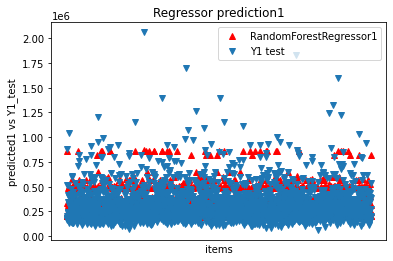

In [62]:
plt.figure()
plt.plot(prediction1, 'r^', label='RandomForestRegressor1')
plt.plot(Y1_test, 'v', label='Y1 test')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test')
plt.xlabel('items')
plt.legend(loc="best")
plt.title('Regressor prediction1')

plt.show()

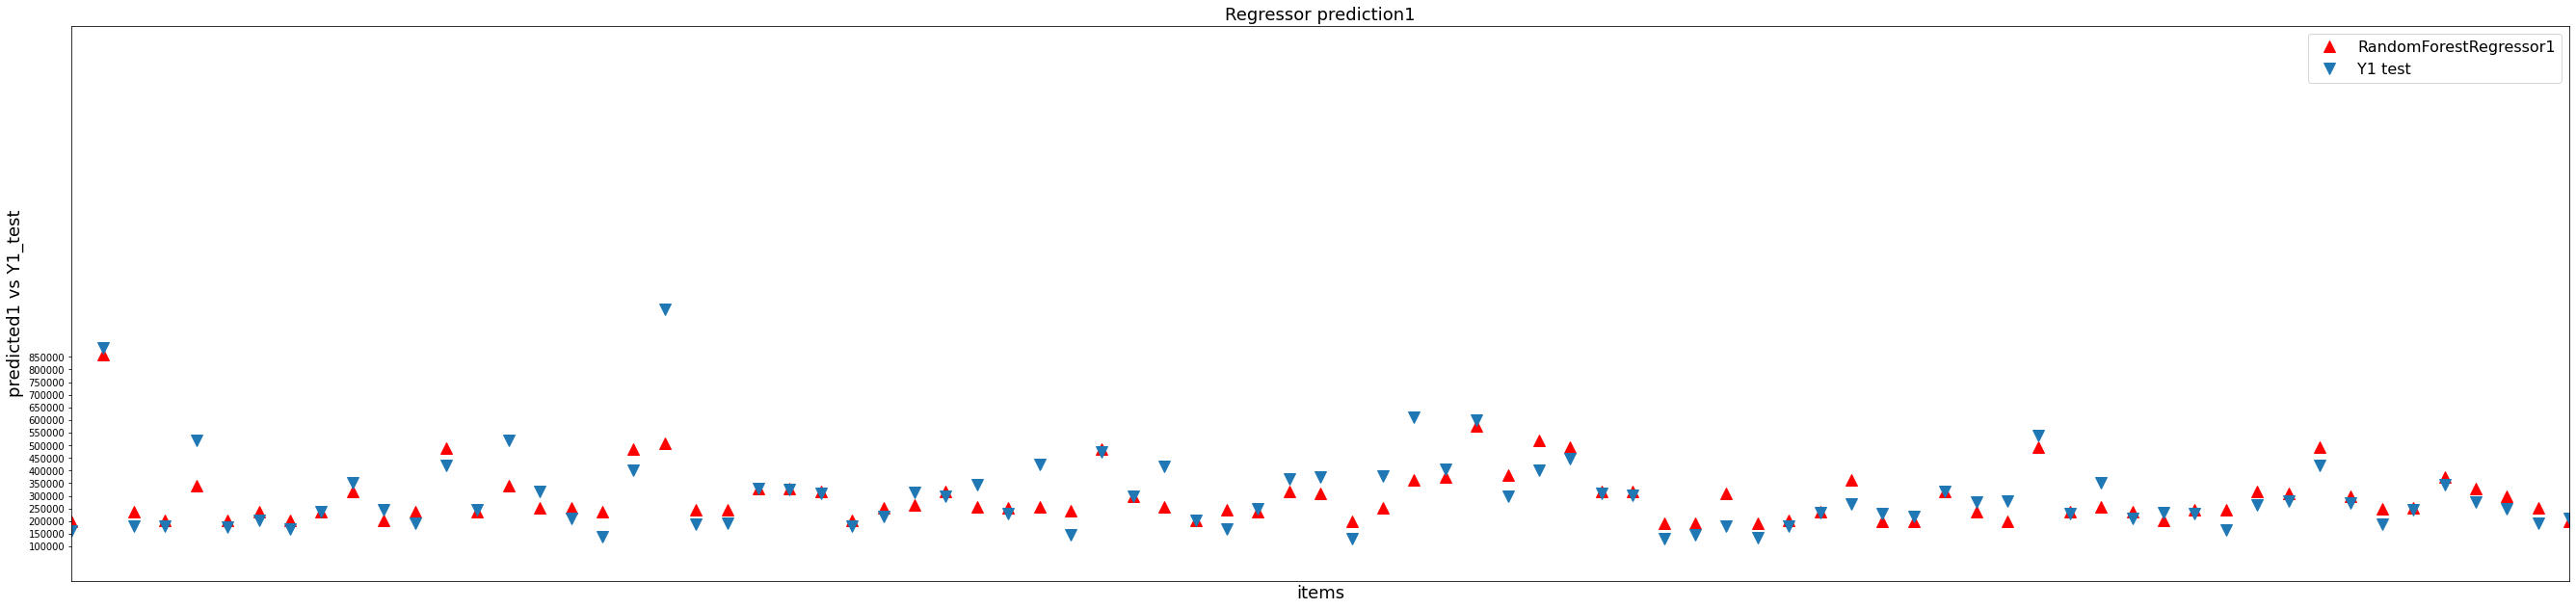

In [63]:
a= plt.figure()
axes= a.add_axes([0,0,6,2])#sequence of [left, bottom, width, height] quantities.
#axes= a.add_axes([0.2,0.2,8,8])
# adding axes
#x= np.arange(0,11)
#axes.plot(prediction, marker='*')
y = np.array([100000, 200000, 300000, 400000, 500000, 600000,700000,800000, 900000])
plt.yticks(np.arange(y.min(), y.max(), 50000))

axes.plot(prediction1, 'r^', label='RandomForestRegressor1',markersize=12)
axes.plot(Y1_test, 'v', label='Y1 test',markersize=12)
axes.set_xlim([0,80])
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test', fontsize=18)
plt.xlabel('items', fontsize=18)
plt.legend(loc="best",prop={'size': 16})
plt.title('Regressor prediction1', fontsize=18)

plt.show()

In [64]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [65]:
mean_squared_error1=metrics.mean_squared_error(prediction1,Y1_test)
mean_squared_error1
root_mse1_2=pow(mean_squared_error1,0.5)
root_mse1_2

113588.59665173272

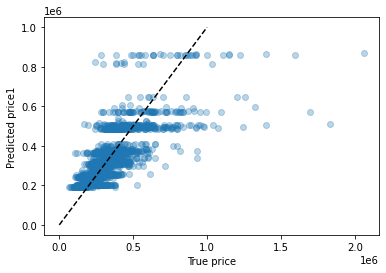

In [66]:
plt.scatter(Y1_test,prediction1,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price1')
plt.show()


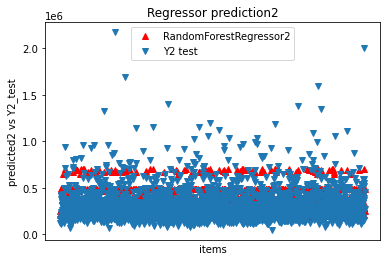

In [ ]:
plt.figure()
plt.plot(prediction2, 'r^', label='RandomForestRegressor2')
plt.plot(Y2_test, 'v', label='Y2 test')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted2 vs Y2_test')
plt.xlabel('items')
plt.legend(loc="best")
plt.title('Regressor prediction2')

plt.show()


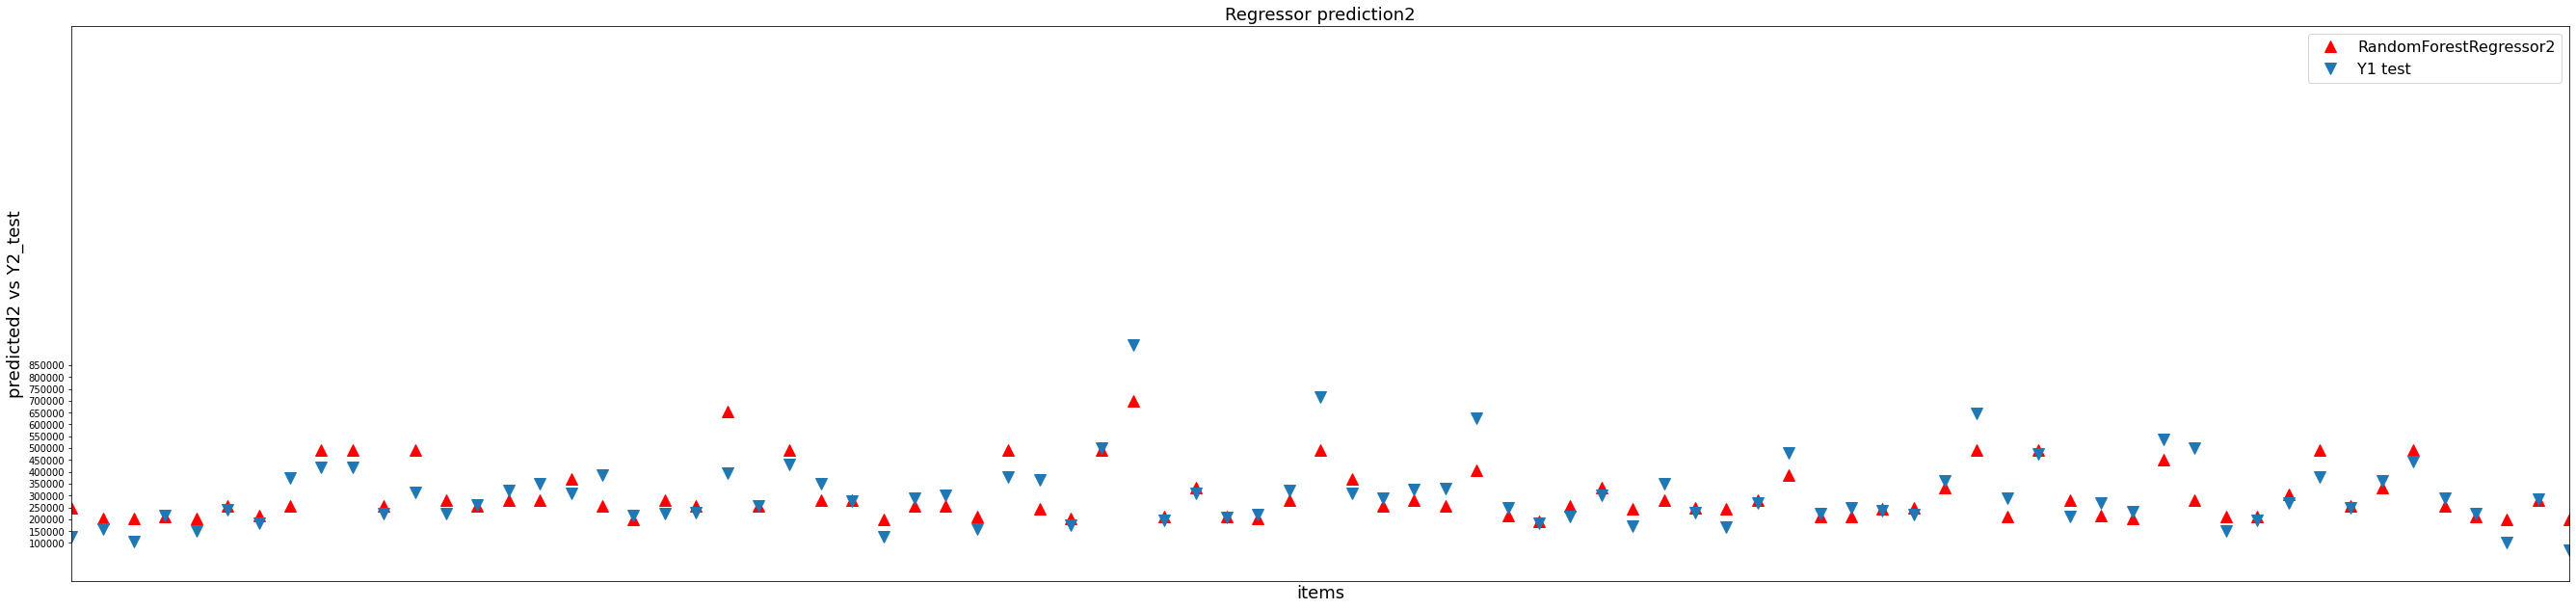

In [ ]:
a= plt.figure()
axes= a.add_axes([0,0,6,2])#sequence of [left, bottom, width, height] quantities.
#axes= a.add_axes([0.2,0.2,8,8])
# adding axes
#x= np.arange(0,11)
#axes.plot(prediction, marker='*')
y = np.array([100000, 200000, 300000, 400000, 500000, 600000,700000,800000, 900000])
plt.yticks(np.arange(y.min(), y.max(), 50000))

axes.plot(prediction2, 'r^', label='RandomForestRegressor2',markersize=12)
axes.plot(Y2_test, 'v', label='Y1 test',markersize=12)
axes.set_xlim([0,80])
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted2 vs Y2_test', fontsize=18)
plt.xlabel('items', fontsize=18)
plt.legend(loc="best",prop={'size': 16})
plt.title('Regressor prediction2', fontsize=18)

plt.show()

In [ ]:
mean_squared_error2=metrics.mean_squared_error(prediction2,Y2_test)
mean_squared_error2
root_mse2_2=pow(mean_squared_error2,0.5)
root_mse2_2

114215.10161613983

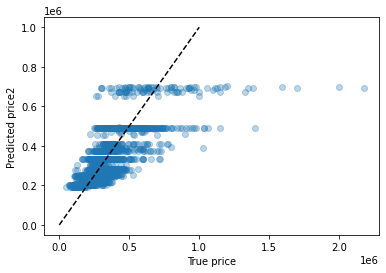

In [ ]:
plt.scatter(Y2_test,prediction2,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price2')
plt.show()